# Pool Elo

In [794]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import csv
from datetime import datetime

# Elo 

In [795]:
# Read Test Dataset 
data = pd.read_csv('data/predatorCLPClean.csv')
data['date'] = pd.to_datetime(data['date'])
fulldf = pd.read_csv("data/fulldf.csv")
fulldf['date'] = pd.to_datetime(fulldf['date'])


In [796]:
data

,Unnamed: 0,matchIndex,playerA,playerB,playerARacks,playerBRacks,playerARacks.1,date,competition
0,0,1,Chris Melling,Ralf Souquet,5,0,5,2021-03-22,2021 Predator CLP
1,1,2,Albin Ouschan,Chris Robinson,5,2,5,2021-03-22,2021 Predator CLP
2,2,3,Kelly Fisher,Niels Feijen,5,4,5,2021-03-22,2021 Predator CLP
3,3,4,Eklent Kaci,Albin Ouschan,5,4,5,2021-03-22,2021 Predator CLP
4,4,5,Niels Feijen,Chris Robinson,5,3,5,2021-03-22,2021 Predator CLP
...,...,...,...,...,...,...,...,...,...
187,187,188,Albin Ouschan,Niels Feijen,5,4,5,2021-03-29,2021 Predator CLP
188,188,189,Naoyuki Oi,David Alcaide,5,4,5,2021-03-29,2021 Predator CLP
189,189,190,Albin Ouschan,Eklent Kaci,5,2,5,2021-03-29,2021 Predator CLP
190,190,191,David Alcaide,Chris Melling,5,2,5,2021-03-29,2021 Predator CLP


In [797]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

players = pd.concat([fulldf.playerA, fulldf.playerB] )
print(players.value_counts().index.unique())
# How many players
nplayers = len(players.value_counts())
nplayers

Index(['Shane Van Boening', 'Niels Feijen', 'Ralf Souquet', 'Albin Ouschan',
       'Eklent Kaci', 'Jayson Shaw', 'Joshua Filler', 'David Alcaide',
       'Ruslan Chinakhov', 'Denis Grabe',
       ...
       'Mohammed Soufi', 'Elvis Calasang', 'Khaled Al Otaibi',
       'Cristopher Tevez Ocamp', 'Sascha Specchia', 'Mee Warren',
       'Jesse Engel', 'Kengo Suzuki', 'ciech Szewczyk', 'Keith Yip'],
      dtype='object', length=1181)


1181

In [798]:

def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

def run_tournament3(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], K, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return(ratings)

In [799]:
ratings = run_tournament3(fulldf)

In [800]:
ratings
ratings.sort_values(by='ratings', ascending = False)[0:25]


,ratings
Jayson Shaw,1962.543734
Fedor Gorst,1913.199769
Eklent Kaci,1912.125834
Liu Haitao,1832.019691
Jung-Lin Chang,1826.401365
Maximilian Lechner,1823.932573
Niels Feijen,1797.188474
Alex Pagulayan,1766.093470
Francisco Sanchez Ruiz,1763.906391
Joshua Filler,1760.465222


In [801]:
playersCLP = pd.concat([data.playerA, data.playerB] )


In [802]:
# Get correct players
playersindex = []
names = []
for player in playersCLP.unique():
    if player in ratings.index:
        playersindex.append(np.where(players.value_counts().index == player)[0][0])
        names.append(np.where(ratings.index == player)[0][0])
playersindex
names

[31, 3, 1002, 4, 1, 2, 196, 25, 7, 15, 84, 44, 1113, 117, 39, 10, 86, 9, 571]

In [803]:
# Games in the prior dataset
players.value_counts()[playersindex]
fullPlayerList = list(players.value_counts()[playersindex].index)
print(fullPlayerList)
# fullPlayerList.append("Kristina Tkach")
# fullPlayerList.append("Kelly Fisher")

CLPratings = ratings.iloc[np.array(names)]
print(CLPratings)
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)

CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )

['Chris Melling', 'Albin Ouschan', 'Kelly Fisher', 'Eklent Kaci', 'Niels Feijen', 'Ralf Souquet', 'Chris Robinson', 'Mieszko Fortunski', 'David Alcaide', 'Darren Appleton', 'Billy Thorpe', 'Naoyuki Oi', 'Kristina Tkach', 'Roberto Gomez', 'Marc Bijsterbosch', 'Alex Kazakis', 'Casper Matikainen', 'Denis Grabe', 'Jasmin Ouschan']
                       ratings
Chris Melling      1491.040347
Albin Ouschan      1738.286633
Kelly Fisher       1482.460484
Eklent Kaci        1912.125834
Niels Feijen       1797.188474
Ralf Souquet       1680.156147
Chris Robinson     1463.262410
Mieszko Fortunski  1759.447016
David Alcaide      1694.401102
Darren Appleton    1633.643797
Billy Thorpe       1642.833641
Naoyuki Oi         1661.518536
Kristina Tkach     1469.514270
Roberto Gomez      1430.687087
Marc Bijsterbosch  1580.552872
Alex Kazakis       1688.982575
Casper Matikainen  1687.175344
Denis Grabe        1734.758377
Jasmin Ouschan     1501.374693


In [804]:
CLPratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,1912.125834
Niels Feijen,1797.188474
Mieszko Fortunski,1759.447016
Albin Ouschan,1738.286633
Denis Grabe,1734.758377
David Alcaide,1694.401102
Alex Kazakis,1688.982575
Casper Matikainen,1687.175344
Ralf Souquet,1680.156147
Naoyuki Oi,1661.518536


In [826]:

def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

import math

def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):

    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
        
    
        loglikelihood += math.log(proba)

        
    return(loglikelihood)

def get_accuracy(newdata, ratings, ELO_WIDTH = ELO_WIDTH):

    accuracy = []
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
        accuracy.append(int(round(proba)) == int(row['playerARacks'] > row['playerBRacks']))
    


        
    return(np.mean(accuracy))

In [827]:
get_loglikelihood(data, CLPratings)

-135.34867808418937

In [828]:
get_accuracy(data, CLPratings)

0.625

In [807]:
data

,Unnamed: 0,matchIndex,playerA,playerB,playerARacks,playerBRacks,playerARacks.1,date,competition
0,0,1,Chris Melling,Ralf Souquet,5,0,5,2021-03-22,2021 Predator CLP
1,1,2,Albin Ouschan,Chris Robinson,5,2,5,2021-03-22,2021 Predator CLP
2,2,3,Kelly Fisher,Niels Feijen,5,4,5,2021-03-22,2021 Predator CLP
3,3,4,Eklent Kaci,Albin Ouschan,5,4,5,2021-03-22,2021 Predator CLP
4,4,5,Niels Feijen,Chris Robinson,5,3,5,2021-03-22,2021 Predator CLP
...,...,...,...,...,...,...,...,...,...
187,187,188,Albin Ouschan,Niels Feijen,5,4,5,2021-03-29,2021 Predator CLP
188,188,189,Naoyuki Oi,David Alcaide,5,4,5,2021-03-29,2021 Predator CLP
189,189,190,Albin Ouschan,Eklent Kaci,5,2,5,2021-03-29,2021 Predator CLP
190,190,191,David Alcaide,Chris Melling,5,2,5,2021-03-29,2021 Predator CLP


# Tuning K

In [808]:
K = np.arange(1, 101, 1)

In [809]:
log_likelihoods = []
for k in K: 
    # Get ratings 
    allratings = run_tournament3(fulldf, K=k)
    
    # Filter ratings 
    CLPratings = allratings.iloc[np.array(names)]
#     CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
    CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
    
    log_likelihoods.append(get_loglikelihood(data, CLPratings))

Optimal K is 11


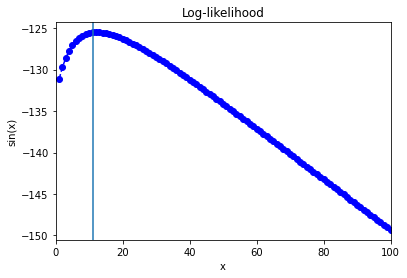

In [810]:
ax = plt.axes()
ax.plot(K, log_likelihoods, '--bo')
ax.axvline(log_likelihoods.index(max(log_likelihoods)))
ax.set(xlim=(0, 100),
       xlabel='K', ylabel='Log-likelihood',
       title='Log-likelihood');

print("Optimal K is " + str(log_likelihoods.index(max(log_likelihoods))))


In [811]:
bestK = log_likelihoods.index(max(log_likelihoods))

In [829]:
# Get ratings 
allratings = run_tournament3(fulldf, K=bestK)
allratings.sort_values(by='ratings', ascending = False)[0:25]



,ratings
Eklent Kaci,1694.105672
Jayson Shaw,1683.649930
Shane Van Boening,1655.888469
Niels Feijen,1641.016996
Fedor Gorst,1639.621830
Albin Ouschan,1636.801225
Joshua Filler,1636.549303
Mario He,1612.730246
Dennis Orcollo,1609.861397
Liu Haitao,1604.103829


In [815]:
players.value_counts()[list(allratings.sort_values(by='ratings', ascending = False)[0:25].index)]


Ken Thompson              4
Nadim Okbani              4
Carlos Cabello            4
Lenny Rakers              4
Mark Todd                 4
Ali al-Obaidly           11
Abder Rehman Mebarki      4
Roberto Gomez            17
Tomasz Kaplan            35
Luu Minh Phuc            11
Mariusz Skoneczny        13
Alejandro Carvajal        7
Meshaal al-Murdhi         7
Huidji See               11
Earl Strickland          18
Kostas Koukiadakis       20
Enrique Rojas             5
Stevie Moore              5
Bashar Hussain           13
Gary Lutman               7
Sundeep Gulati            5
Adam Mscisz               5
Robert Hart               6
Abdul Latif al-Fawal     11
Mohammad-Ali Berjaoui    14
dtype: int64

In [817]:
allratings.sort_values(by='ratings', ascending = False)[len(players.value_counts())-40:len(players.value_counts())]

,ratings
Chris Lawson,1479.799727
Michael Yednak,1479.715372
Michael Leahy,1479.655094
Ali Abdulhadi Almeri,1479.486952
Mohammed Hassan,1479.447653
Jason Theron,1479.360231
Mohammad Soufi,1479.199824
Gabriel Syarov,1479.162162
Ivar Saris,1479.135171
Mohd Al Bin Ali,1478.895367


In [ ]:
players.value_counts()[list(allratings.sort_values(by='ratings', ascending = False)[len(players.value_counts())-25:len(players.value_counts())].index)]

In [831]:
# Filter ratings 
CLPratings = allratings.iloc[np.array(names)]
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
CLPratings.sort_values(by='ratings', ascending = False)

,ratings
Eklent Kaci,1694.105672
Niels Feijen,1641.016996
Albin Ouschan,1636.801225
David Alcaide,1602.238394
Denis Grabe,1601.604669
Ralf Souquet,1600.081964
Alex Kazakis,1587.107941
Mieszko Fortunski,1577.962829
Darren Appleton,1553.992544
Casper Matikainen,1549.550753


In [832]:
get_accuracy(data, CLPratings)

0.6302083333333334

In [835]:
accuracies = []
for k in K: 
    # Get ratings 
    allratings = run_tournament3(fulldf, K=k)
    
    # Filter ratings 
    CLPratings = allratings.iloc[np.array(names)]
#     CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
    CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
    
    accuracies.append(get_accuracy(data, CLPratings))

Optimal K is 13


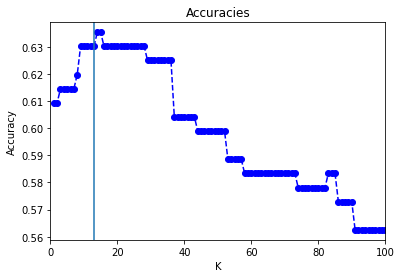

In [836]:
ax = plt.axes()
ax.plot(K, accuracies, '--bo')
ax.axvline(accuracies.index(max(accuracies)))
ax.set(xlim=(0, 100),
       xlabel='K', ylabel='Accuracy',
       title='Accuracies');

print("Optimal K is " + str(accuracies.index(max(accuracies))))



# Update Posterior Ratings after Predator CLP

In [818]:

def run_tournament_with_prior_ratings(data, priorratings, ELO_WIDTH = ELO_WIDTH, K=bestK):
    

    # Initialize Elo Ratings
    elo_ratings = priorratings

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        k=K
#         if row['isSemi'] == True: 
#             k = K*2
#         elif row['isFinal'] == True: 
#             k = K*3
#         else: 
#             k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings.loc[winner][0], elo_ratings.loc[loser][0], k, ELO_WIDTH)
        elo_ratings.loc[winner][0] = new_winner_rating
        elo_ratings.loc[loser][0] = new_loser_rating
    return(elo_ratings)

In [819]:
posterior_ratings = run_tournament_with_prior_ratings(data, priorratings = CLPratings)

In [820]:
posterior_ratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,2076.056222
Niels Feijen,1852.814433
Albin Ouschan,1848.922686
Denis Grabe,1818.641877
David Alcaide,1803.561558
Mieszko Fortunski,1790.536415
Naoyuki Oi,1776.267705
Alex Kazakis,1769.146260
Casper Matikainen,1746.929839
Billy Thorpe,1722.042210


# Varying K 

In [697]:
# Elo Rating System 
# Constants
INITIAL_RATING = 0
ELO_WIDTH = 400

def expected_Glickman(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** (-1 * (A - B) / elo_width))
    return( proba )

def standard_update_elo_Glickman(Rpre, Ropp, S, k, m0, elo_width):
    expected_win = expected(Rpre, Ropp, elo_width)
    T = 14
    if (k *(S-expected_win)) <= (T * np.sqrt(m0)[0]): 
        B = 0
    else: 
        B = k *(S-expected_win) - (T * np.sqrt(m0)[0])
    Rpost = Rpre + k *(S-expected_win) + B
    return Rpost

def special_update_elo_Glickman(Rpre, Ropp, N, WL, m, elo_width):
    Rpost = (N * Rpre + m * Ropp + WL*elo_width)/(N + m)
    return Rpost





def run_tournament_varyingK(data, priorratings, priorgames, ELO_WIDTH = ELO_WIDTH, dictflag=False, consolidation = False):
    
    # Initialize Elo Ratings
    tournamentgames = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )
    elo_ratings = priorratings
    WLrecord = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )
    opponentrating = pd.DataFrame(np.zeros(len( priorratings.index), dtype=int), index= priorratings.index )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        playerA = row["playerA"]
        playerB = row["playerB"]
        if consolidation: 
            playerA = switcher(row["playerA"])
            playerB = switcher(row["playerB"])
            
        tournamentgames.loc[playerA] += 1
        tournamentgames.loc[playerB] += 1
        mA = tournamentgames.loc[playerA]
        mB = tournamentgames.loc[playerB]
#         print(tournamentgames)
        
        Apre = elo_ratings.loc[playerA][0]
        Bpre = elo_ratings.loc[playerB][0]
        SA = row['playerARacks'] > row['playerBRacks'] 
        SB = row['playerBRacks'] > row['playerARacks'] 
        
        if SA: 
            WLrecord.loc[playerA] += 1
        else: 
            WLrecord.loc[playerA] -= 1
            
        if SB: 
            WLrecord.loc[playerB] += 1
        else: 
            WLrecord.loc[playerB] -= 1

        if dictflag:
            NA = priorgames.loc[playerA][0]
            NB = priorgames.loc[playerB][0]
        else:
            NA = priorgames[playerA]
            NB = priorgames[playerB]
            

        
        if NA < 50: 
            ANr = 50/np.sqrt(0.662 + 0.00000739*(2569 - Apre)**2)
        else: 
            ANr = 50
        if NB < 50: 
            BNr = 50/np.sqrt(0.662 + 0.00000739*(2569 - Bpre)**2)
        else: 
            BNr = 50
            
        Ne = min(ANr, BNr)
        
        if NA <=8: 
            Apost = special_update_elo_Glickman(Apre, Bpre, NA, WLrecord.loc[playerA][0], mA, ELO_WIDTH)
        else: 
            K = 800/ (NA + Ne)
            Apost = standard_update_elo_Glickman(Apre, Bpre, SA, K, mA, ELO_WIDTH)
        
        if NB <=8: 
            Bpost = special_update_elo_Glickman(Bpre, Apre, NB, WLrecord.loc[playerB][0], mB, ELO_WIDTH)
        else: 
            K = 800/ (NB + Ne)
            Bpost = standard_update_elo_Glickman(Bpre, Apre, SB, K, mB, ELO_WIDTH)
        
        if dictflag:
            priorgames.loc[playerA][0] += 1
            priorgames.loc[playerB][0] += 1 
        else:
            priorgames[playerA] += 1
            priorgames[playerB] += 1
        
        elo_ratings.loc[playerA][0] = Apost
        elo_ratings.loc[playerB][0] = Bpost
    return(elo_ratings)



In [698]:
players.value_counts()[np.array(names)]

Chris Melling         54
Albin Ouschan         73
Kelly Fisher           2
Eklent Kaci          125
Niels Feijen          88
Ralf Souquet          82
Chris Robinson         9
Mieszko Fortunski     42
David Alcaide        100
Darren Appleton       81
Billy Thorpe          23
Naoyuki Oi            43
Kristina Tkach         1
Roberto Gomez         17
Marc Bijsterbosch     23
Alex Kazakis         108
Casper Matikainen     81
Denis Grabe           76
Jasmin Ouschan         4
dtype: int64

In [699]:
playergames = players.value_counts()
print(playergames)



Shane Van Boening       132
Konrad Juszczyszyn      131
Eklent Kaci             125
Ruslan Chinakhov        120
Mateusz Sniegocki       119
                       ... 
Angel Gabriel Acosta      1
Ang Tuan Nguyen           1
Bogdan Alin Stoian        1
Marlon Villamor           1
Hugo Duivenvoorden        1
Length: 1144, dtype: int64


In [700]:
ratings = run_tournament_varyingK(data, priorratings = CLPratings, priorgames=playergames).sort_values(by='ratings', ascending = False)
ratings

,ratings
Eklent Kaci,2055.898817
Albin Ouschan,1996.975385
Niels Feijen,1980.624883
Naoyuki Oi,1970.884440
Alex Kazakis,1929.651850
Ralf Souquet,1910.175430
Darren Appleton,1901.292953
Mieszko Fortunski,1893.443374
Chris Melling,1879.667599
David Alcaide,1859.311249


In [701]:
allratings

,ratings
Shane Van Boening,2047.261892
Konrad Juszczyszyn,2111.007685
Eklent Kaci,2042.723933
Ruslan Chinakhov,1805.061107
Mateusz Sniegocki,2074.927597
...,...
Angel Gabriel Acosta,1562.319995
Ang Tuan Nguyen,1414.623308
Bogdan Alin Stoian,1100.000000
Marlon Villamor,1432.737013


In [754]:
# init = pd.DataFrame(np.zeros_like(allratings), index = allratings.index).rename(columns={0:'ratings'})
playersgreaterthan10 = players.value_counts()[players.value_counts() > 10]

playergamedictionary = {}

players.value_counts().index.unique()

for i in players.value_counts()[players.value_counts() <= 10].index.unique():
    if i in list(CLPratings.index):
        print(i)
        pass
    else:
        playergamedictionary[i] = "Player " + str(players.value_counts()[players.value_counts().index == i][0])

playergamedictionary
fulldf_version = fulldf.copy()
fulldf_version


Chris Robinson
Jasmin Ouschan
Kelly Fisher
Kristina Tkach


,Unnamed: 0,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,0,1,329B-01,2007-10-14 00:00:00,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,1,2,329B-02,2007-10-14 00:00:00,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball
2,2,3,329B-03,2007-10-14 00:00:00,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball
3,3,4,329B-04,2007-10-14 00:00:00,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,4,5,329B-05,2007-10-14 00:00:00,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...,...
4781,4781,417,NaN,2020-02-22 12:00:00,Eklent Kaci,9,Maximilian Lechner,0,2020 EuroTour Treviso
4782,4782,418,NaN,2020-02-22 12:00:00,Mickey Krause,4,Mateusz Sniegocki,9,2020 EuroTour Treviso
4783,4783,419,NaN,2020-02-22 14:00:00,Fedor Gorst,3,Jayson Shaw,9,2020 EuroTour Treviso
4784,4784,420,NaN,2020-02-22 15:30:00,Eklent Kaci,9,Mateusz Sniegocki,6,2020 EuroTour Treviso


In [755]:
playergamedictionary

{'Bora Anar': 'Player 10',
 'Jani Siekkinen': 'Player 10',
 'Elliott Sanderson': 'Player 10',
 'Robbie Capito': 'Player 10',
 'Mariusz Skoneczny': 'Player 10',
 'Aleksa Pecelj': 'Player 10',
 'Szu-Ting Kuo': 'Player 10',
 'Moritz Lauwereyns': 'Player 10',
 'Michael Yednak': 'Player 10',
 'Artem Koshovyi': 'Player 10',
 'Stanimir Ruslanow': 'Player 10',
 'Arjan Matrizi': 'Player 10',
 'Satoshi Kawabata': 'Player 10',
 'Francesco Candela': 'Player 10',
 'Abdullah al-Yousif': 'Player 9',
 'Donny Branson': 'Player 9',
 'Tom Teriault': 'Player 9',
 'Do The Kien': 'Player 9',
 'Kenichi Uchigaki': 'Player 9',
 'Liu Cheng Chieh': 'Player 9',
 'Blake Baker': 'Player 9',
 'Menelaos Lolas': 'Player 9',
 'Osman Sanlisoy': 'Player 9',
 'Han Haoxiang': 'Player 9',
 'Salah Al Riwani': 'Player 9',
 'Raj Hundal': 'Player 9',
 'Sergey Lutsker': 'Player 9',
 'Ali Maghsoud': 'Player 9',
 'Jeppe Thyde': 'Player 9',
 'Sean Morgan': 'Player 9',
 'Henrique Correia': 'Player 9',
 'Pepijn DeWit': 'Player 9',
 '

In [756]:
def switcher(argument):
        switcher = playergamedictionary

        # get() method of dictionary data type returns 
        # value of passed argument if it is present 
        # in dictionary otherwise second argument will
        # be assigned as default value of passed argument
        val = switcher.get(argument, "nothing")
        if val == "nothing":
            return argument
        else:
#             print(val)
            return val
def consolidatestrings(series):
    
    lst = []
    for idx, item in enumerate(series): 
        lst.append(switcher(item))
#     print(lst)
    return(lst)
   
    

fulldf_version["playerA"] = consolidatestrings(fulldf_version["playerA"])
fulldf_version["playerB"] = consolidatestrings(fulldf_version["playerB"])

fulldf_version

,Unnamed: 0,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,0,1,329B-01,2007-10-14 00:00:00,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,1,2,329B-02,2007-10-14 00:00:00,Ernesto Dominguez,11,Player 7,5,2007 US Open 9-Ball
2,2,3,329B-03,2007-10-14 00:00:00,Player 1,11,Player 4,5,2007 US Open 9-Ball
3,3,4,329B-04,2007-10-14 00:00:00,Player 2,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,4,5,329B-05,2007-10-14 00:00:00,Francisco Bustamante,11,Player 1,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...,...
4781,4781,417,NaN,2020-02-22 12:00:00,Eklent Kaci,9,Maximilian Lechner,0,2020 EuroTour Treviso
4782,4782,418,NaN,2020-02-22 12:00:00,Mickey Krause,4,Mateusz Sniegocki,9,2020 EuroTour Treviso
4783,4783,419,NaN,2020-02-22 14:00:00,Fedor Gorst,3,Jayson Shaw,9,2020 EuroTour Treviso
4784,4784,420,NaN,2020-02-22 15:30:00,Eklent Kaci,9,Mateusz Sniegocki,6,2020 EuroTour Treviso


In [764]:
filtered_list = list(set(playergamedictionary.values()))
for i in list(players.value_counts()[players.value_counts() > 10].index):
    filtered_list.append(i)

for i in players.value_counts()[players.value_counts() <= 10].index.unique():
    if i in list(CLPratings.index):
        filtered_list.append(i)
    

# filtered_list

[8, 1, 13, 0, 2, 5, 18, 7, 9, 6, 16, 3, 15, 14, 11, 4, 10, 12, 17]

In [761]:
# Get ratings 


init = pd.DataFrame(np.zeros(len(filtered_list)), index = index).rename(columns={0:'ratings'})
allratings = run_tournament_varyingK(fulldf_version, init + 1500, init, dictflag =True, consolidation=True)
allratings.sort_values(by='ratings', ascending = False)[0:40]


,ratings
Li He Wen,2312.065429
Antonio Lining,2292.075119
Francisco Bustamante,2281.337212
Yu-Lung Chang,2224.186972
Roland Garcia,2218.217781
Wu Kun-Lin,2153.937696
Oliver Ortmann,2144.204593
Kai-Lun Hsu,2124.493328
James Aranas,2119.697503
Liu Ri Teng,2097.791497


In [765]:
# Get correct players
playersindex = []
names = []
for player in playersCLP.unique():
    if player in allratings.index:
        playersindex.append(np.where(players.value_counts().index == player)[0][0])
        names.append(np.where(allratings.index == player)[0][0])
playersindex
names

[46,
 30,
 188,
 12,
 20,
 24,
 186,
 54,
 17,
 26,
 100,
 53,
 189,
 123,
 101,
 16,
 25,
 28,
 187]

In [769]:
# Games in the prior dataset
players.value_counts()[playersindex]
fullPlayerList = list(players.value_counts()[playersindex].index)
print(fullPlayerList)
# fullPlayerList.append("Kristina Tkach")
# fullPlayerList.append("Kelly Fisher")

CLPratings = allratings.iloc[np.array(names)]
print(CLPratings)
# CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)

CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )

# # Filter ratings 
# CLPratings = allratings.iloc[np.array(names)]
# # CLPratings = CLPratings.append([{"ratings": 1500}], ignore_index = True)
# CLPratings = CLPratings.set_index( index )
CLPratings.sort_values(by='ratings', ascending = False)

['Chris Melling', 'Albin Ouschan', 'Kelly Fisher', 'Eklent Kaci', 'Niels Feijen', 'Ralf Souquet', 'Chris Robinson', 'Mieszko Fortunski', 'David Alcaide', 'Darren Appleton', 'Billy Thorpe', 'Naoyuki Oi', 'Kristina Tkach', 'Roberto Gomez', 'Marc Bijsterbosch', 'Alex Kazakis', 'Casper Matikainen', 'Denis Grabe', 'Jasmin Ouschan']
                       ratings
Chris Melling      1894.953504
Albin Ouschan      1899.952033
Kelly Fisher       1728.205694
Eklent Kaci        1991.807722
Niels Feijen       1849.330418
Ralf Souquet       1910.653933
Chris Robinson     1639.409561
Mieszko Fortunski  1940.487671
David Alcaide      1848.802582
Darren Appleton    1805.418114
Billy Thorpe       1530.079361
Naoyuki Oi         1883.549014
Kristina Tkach     1266.533214
Roberto Gomez      1723.302031
Marc Bijsterbosch  1509.745363
Alex Kazakis       1865.258891
Casper Matikainen  1831.001462
Denis Grabe        1765.244747
Jasmin Ouschan     1624.586179


,ratings
Eklent Kaci,1991.807722
Mieszko Fortunski,1940.487671
Ralf Souquet,1910.653933
Albin Ouschan,1899.952033
Chris Melling,1894.953504
Naoyuki Oi,1883.549014
Alex Kazakis,1865.258891
Niels Feijen,1849.330418
David Alcaide,1848.802582
Casper Matikainen,1831.001462


In [770]:
def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):

    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        winnerrating = ratings.loc[winner]
        loserrating = ratings.loc[loser]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
#         print(proba)
    
        loglikelihood += math.log(proba)

        
    return(loglikelihood)

In [771]:
get_loglikelihood(data, CLPratings)

-142.3833440276898

In [772]:
ratings = run_tournament_varyingK(data, priorratings = CLPratings, priorgames=playergames).sort_values(by='ratings', ascending = False)
ratings

,ratings
Eklent Kaci,1994.994305
Albin Ouschan,1902.738178
Chris Melling,1900.842405
Ralf Souquet,1889.218330
Mieszko Fortunski,1887.564431
Naoyuki Oi,1875.184791
David Alcaide,1865.127168
Alex Kazakis,1862.206402
Niels Feijen,1855.517784
Casper Matikainen,1812.320480



# Sandbox Code 

In [70]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

In [69]:
def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

In [469]:

def run_tournament(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, k=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner = row["WinnerName"]
        loser = row["LoserName"]
        if row['isSemi'] == True: 
            k = K*2
        elif row['isFinal'] == True: 
            k = K*3
        else: 
            k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], k, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating

    return(elo_ratings)

In [470]:
ratings = run_tournament()

KeyError: 'WinnerName'

In [100]:
ratings.sort_values(by='ratings', ascending = False)

,ratings
Shannon Murphy,1475.0
Robby Foldvari,1475.0
Jang Moonseok,1475.0
Francois Ellis,1475.0
Himanshu Jain,1475.0
...,...
Albin Ouschan,800.0
Jayson Shaw,775.0
Alex Pagulayan,750.0
Dennis Orcollo,750.0


In [101]:
# Train-Test Split
winnersgroup = data[data.Group == 8]
prelims = data[data.Group != 8]

In [102]:
ratingsPrelims = run_tournament(data=prelims)

KeyError: 'Kelly Fisher'

In [103]:
ratingsPrelims
ratingsPrelims.sort_values(by='ratings', ascending = False)


NameError: name 'ratingsPrelims' is not defined